In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("osmi/mental-health-in-tech-survey")

print("Path to dataset files:", path)


100%|██████████| 48.8k/48.8k [00:00<00:00, 21.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3


2️⃣ Cargar el dataset en PySpark


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MentalHealth").getOrCreate()

# The dataset was downloaded to /root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3
df = spark.read.csv("/root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3/survey.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-------------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+------------------+-------------------------+-----------------------+------------+----------+-----------------------+---------------------+------------------+---------------+--------+
|          Timestamp|Age|Gender|       Country|state|self_employed|family_history|treatment|work_interfere|  no_employees|remote_work|tech_company|  benefits|care_options|wellness_program| seek_help| anonymity|             leave|mental_health_consequence|phys_health_consequence|   coworkers|supervisor|mental_health_interview|phys_health_interview|mental_vs_physical|obs_consequence|comments|
+-------------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+--

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, when, count, round

# Iniciar sesión Spark
spark = SparkSession.builder.appName("MentalHealth").getOrCreate()

# Cargar dataset
# The dataset was downloaded to /root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3
df = spark.read.csv("/root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3/survey.csv", header=True, inferSchema=True)

# Ver primeras filas
df.show(5)

# Estandarizar texto en Country y Gender
df = df.withColumn("Country", trim(col("Country"))) \
       .withColumn("Gender", lower(trim(col("Gender"))))

# Opcional: normalizar categorías de género (simplificación)
df = df.withColumn("Gender", when(col("Gender").like("%female%"), "Female")
                                 .when(col("Gender").like("%male%"), "Male")
                                 .otherwise("Other"))

# Filtrar nulos relevantes
df = df.na.drop(subset=["Country", "Gender", "tech_company", "mental_health_interview"])

# Crear métrica % que respondería "Yes" a mental_health_interview
total_df = df.groupBy("Country").count().withColumnRenamed("count", "total_responses")

yes_df = df.filter(col("mental_health_interview") == "Yes") \
           .groupBy("Country").count().withColumnRenamed("count", "yes_responses")

# Unir y calcular porcentaje
result = total_df.join(yes_df, on="Country", how="left") \
                 .withColumn("yes_responses", when(col("yes_responses").isNull(), 0).otherwise(col("yes_responses"))) \
                 .withColumn("pct_yes", round((col("yes_responses") / col("total_responses")) * 100, 2))

result.show()

+-------------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+------------------+-------------------------+-----------------------+------------+----------+-----------------------+---------------------+------------------+---------------+--------+
|          Timestamp|Age|Gender|       Country|state|self_employed|family_history|treatment|work_interfere|  no_employees|remote_work|tech_company|  benefits|care_options|wellness_program| seek_help| anonymity|             leave|mental_health_consequence|phys_health_consequence|   coworkers|supervisor|mental_health_interview|phys_health_interview|mental_vs_physical|obs_consequence|comments|
+-------------------+---+------+--------------+-----+-------------+--------------+---------+--------------+--------------+-----------+------------+----------+------------+----------------+----------+----------+--

In [13]:
# Convertir el DataFrame result a Pandas
result_pd = result.toPandas()

# Guardar como CSV
result_pd.to_csv('mental_health_clean.csv', index=False)

# Descargar
from google.colab import files
files.download('mental_health_clean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graficamos con Matplotlib

In [16]:
df_pd = df.toPandas()


1. Distribución por país

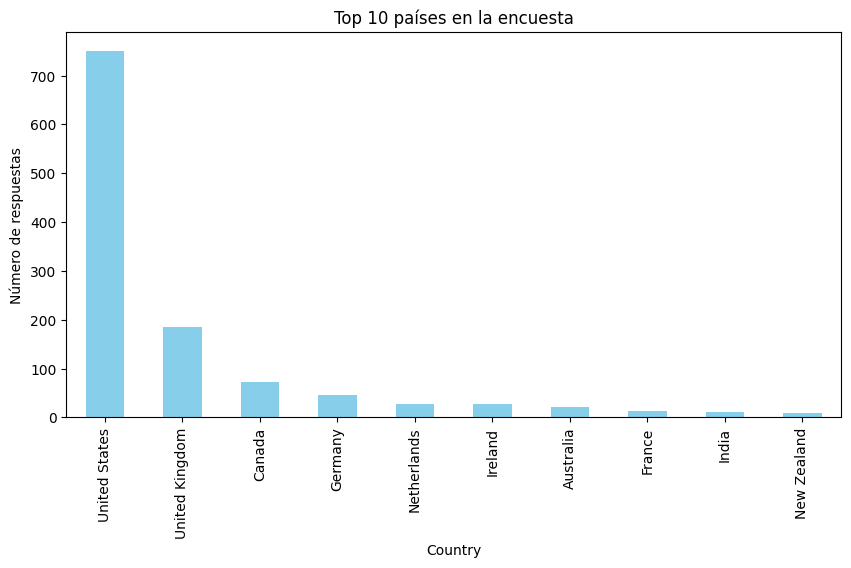

In [17]:
import matplotlib.pyplot as plt

top_paises = df_pd['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_paises.plot(kind='bar', color='skyblue')
plt.title("Top 10 países en la encuesta")
plt.ylabel("Número de respuestas")
plt.show()


2. Distribución por género

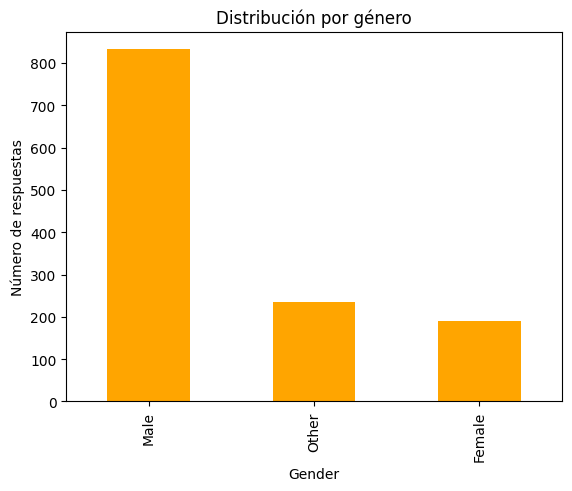

In [18]:
df_pd['Gender'].value_counts().plot(kind='bar', color='orange')
plt.title("Distribución por género")
plt.ylabel("Número de respuestas")
plt.show()


3. ¿Tienen antecedentes familiares de enfermedad mental? (family_history)

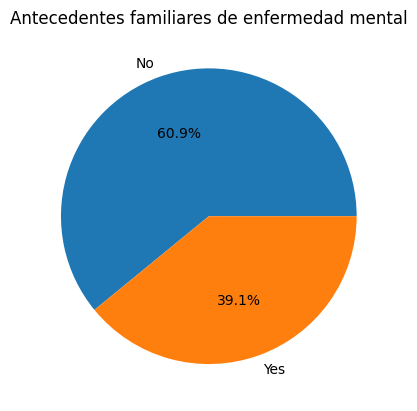

In [19]:
df_pd['family_history'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Antecedentes familiares de enfermedad mental")
plt.ylabel("")
plt.show()


4. Tratamiento (treatment)

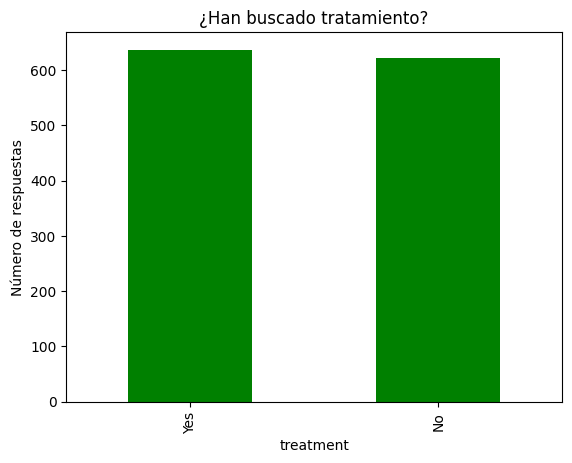

In [20]:
df_pd['treatment'].value_counts().plot(kind='bar', color='green')
plt.title("¿Han buscado tratamiento?")
plt.ylabel("Número de respuestas")
plt.show()


5. Trabajo remoto (remote_work)

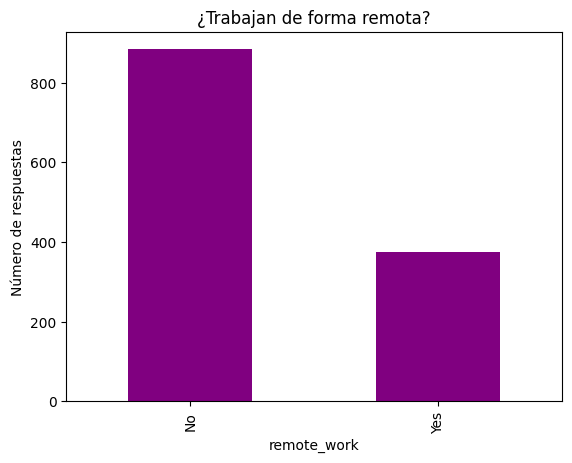

In [21]:
df_pd['remote_work'].value_counts().plot(kind='bar', color='purple')
plt.title("¿Trabajan de forma remota?")
plt.ylabel("Número de respuestas")
plt.show()


6. Comparación: ¿Beneficios de salud mental por tipo de empresa?

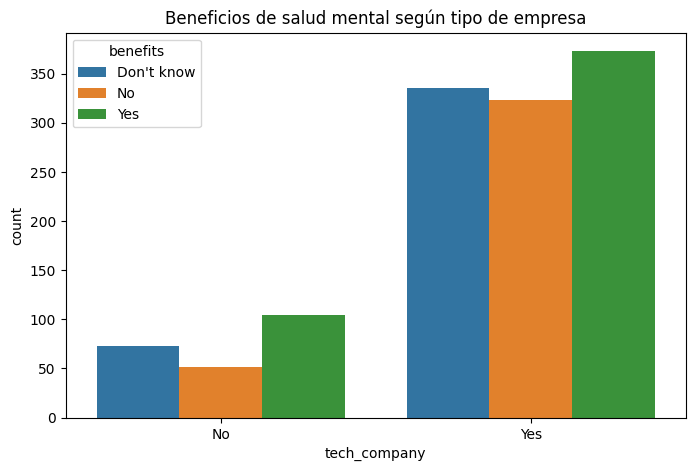

In [22]:
import seaborn as sns

beneficios = df_pd.groupby(['tech_company', 'benefits']).size().reset_index(name='count')
plt.figure(figsize=(8,5))
sns.barplot(data=beneficios, x='tech_company', y='count', hue='benefits')
plt.title("Beneficios de salud mental según tipo de empresa")
plt.show()
